# Soft Actor Critic Agent(115 Points)

> Name: Vahid Pourakbar

> SID: 400205511



In this notebook, we are going to implement **Soft Actor Critic (SAC)**
on the **CartPole** environment in online and offline settings. In this framework, the actor aims to maximize the expected reward while also maximizing **entropy**. That is, to succeed at the task while acting as randomly as possible. This method seeks a high entropy in the policy to explicitly encourage exploration. For the offline setting, you are going to make SAC conservative using CQL method.

* SAC is an off-policy algorithm.
* The version of SAC implemented here can only be used for environments with discrete action spaces.
* An alternate version of SAC, which slightly changes the policy update  rule, can be implemented to handle continuous action spaces.
* Complete the **TODO** parts in the code accordingly.
* Remember to answer the conceptual questions.




In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
import numpy as np
import random
import gym
import matplotlib.pyplot as plt


seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Network Structure (8 points)
For constructing SAC agent, we use objects of feedforward neural networks with 3 layers. Complete the code below.

In [67]:
class Network(torch.nn.Module):

    def __init__(self, input_dimension, output_dimension, output_activation=torch.nn.Identity()):
        super(Network, self).__init__()
        ##########################################################
        # TODO (4 points):
        # Define your network layers.
        ##########################################################
        self.layer_1 = torch.nn.Linear(input_dimension, 64)
        self.layer_2 = torch.nn.Linear(64, 64)
        self.output_layer = torch.nn.Linear(64, output_dimension)
        self.output_activation = output_activation
        ##########################################################

    def forward(self, inpt):
        output = None
        ##########################################################
        # TODO (4 points):
        # Use relu and the output activation functions to calculate the output
        ##########################################################
        layer_1_outpt = torch.nn.functional.relu(self.layer_1(inpt))
        layer_2_outpt = torch.nn.functional.relu(self.layer_2(layer_1_outpt))
        output = self.output_activation(self.output_layer(layer_2_outpt))
        return output
        ##########################################################

## Replay Buffer

A SAC agent needs a replay buffer, from which previously visited states can be sampled. You can use the implemented code below. You are going to use the replay buffer of a pretrained online agent to train the offline model.

In [68]:
import numpy as np


class ReplayBuffer:

    def __init__(self, environment, capacity=500000):
        transition_type_str = self.get_transition_type_str(environment)
        self.buffer = np.zeros(capacity, dtype=transition_type_str)
        self.weights = np.zeros(capacity)
        self.head_idx = 0
        self.count = 0
        self.capacity = capacity
        self.max_weight = 10**-2
        self.delta = 10**-4
        self.indices = None
        self.mirror_index = np.random.permutation(range(self.buffer.shape[0]))

    def get_transition_type_str(self, environment):
        state_dim = environment.observation_space.shape[0]
        state_dim_str = '' if state_dim == () else str(state_dim)
        state_type_str = environment.observation_space.sample().dtype.name
        action_dim = environment.action_space.shape
        action_dim_str = '' if action_dim == () else str(action_dim)
        action_type_str = environment.action_space.sample().__class__.__name__

        # type str for transition = 'state type, action type, reward type, state type'
        transition_type_str = '{0}{1}, {2}{3}, float32, {0}{1}, bool'.format(state_dim_str, state_type_str,
                                                                             action_dim_str, action_type_str)

        return transition_type_str

    def add_transition(self, transition):
        self.buffer[self.head_idx] = transition
        self.weights[self.head_idx] = self.max_weight

        self.head_idx = (self.head_idx + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample_minibatch(self, size=100, batch_deterministic_start=None):
        set_weights = self.weights[:self.count] + self.delta
        probabilities = set_weights / sum(set_weights)
        if batch_deterministic_start is None:
            self.indices = np.random.choice(range(self.count), size, p=probabilities, replace=False)
        else:
            self.indices = self.mirror_index[batch_deterministic_start:batch_deterministic_start+size]
        return self.buffer[self.indices]

    def update_weights(self, prediction_errors):
        max_error = max(prediction_errors)
        self.max_weight = max(self.max_weight, max_error)
        self.weights[self.indices] = prediction_errors

    def get_size(self):
        return self.count

## Questions (18 points)

❓ We know that standard RL maximizes the expected sum of rewards. What is the objective function of SAC algorithm? Compare it to the standard RL loss.

The Soft Actor-Critic (SAC) algorithm is a variant of reinforcement learning that seeks to maximize the expected sum of rewards while also encouraging exploration through maximizing entropy. The objective function of SAC can be written as:
$$J(\theta) = \mathbb{E}_\pi [\sum_{t=0}^T \gamma^t(r_t + \alpha H(\pi(a_t|s_t)))]$$
where $\theta$ are the parameters of the policy $\pi$, $\gamma$ is the discount factor, $r_t$ is the reward at time step $t$, $\alpha$ is a temperature parameter that controls the trade-off between maximizing expected return and maximizing entropy, $H(\pi(a_t|s_t))$ is the entropy of the policy distribution at time step $t$, and $T$ is the time horizon.

Compared to the standard RL loss, which only maximizes the expected sum of rewards (without considering entropy), SAC seeks to find a policy that not only maximizes expected rewards but also encourages exploration and avoids premature convergence to suboptimal policies.

❓ Write down the actor cost function.

This representation of the actor cost function minimizes the KL divergence between the policy, π, and an exponentiated Q-function as a target distribution.

$$J_{\pi}(\theta) = \mathbb{E}_{s_t \sim D}[D_{KL}(\pi_{\theta}(.|s_t) \parallel \frac{e^{Q_{\phi}(s_t, a_t)}}{Z_{\phi}(s_t)})]$$

Here, $D_{KL}$ represents the Kullback-Leibler (KL) divergence, $Q_{\phi}(s_t, a_t)$ represents the Q-value estimate from the critic with parameters $\phi$, and $Z_{\phi}(s_t)$ is the normalizing constant ensuring that the target is a proper probability distribution.

❓ Write down the critic cost function.

The critic cost function here aims to minimize the mean squared error between the current Q-value estimate and the target value, y. The target value is constructed using the reward, the next state, and the next action sampled from the current policy.

$$ J_{Q}(\phi) = \mathbb{E}_{(s,a,r,s',d) \sim D}[(Q_{\phi}(s,a) - y)^2]$$

$$y = r + \gamma (1-d) \mathbb{E}_{a' \sim \pi_{\theta}(a' | s')}[Q_{\phi}(s', a')]$$


❓ Elaborate on the reason why most implementations of SAC use two critics (one local and one target).

In Soft Actor-Critic (SAC) and several other deep reinforcement learning algorithms, it is common to use two critic networks (referred to as twin or double Q-networks) and a target network for stability and to mitigate overestimation bias. Let's break down the reasons:

1. **Mitigating Overestimation Bias**: Overestimation bias arises when the critic network's estimated Q-values are systematically higher than the true Q-values. This is especially common in environments with high variance or noisy rewards. Using two critic networks and taking the minimum Q-value between the two for updating the policy and the critic itself helps to mitigate this bias. Essentially, it's less likely that both critics would overestimate the Q-value simultaneously, so taking the minimum is a kind of conservative estimate that mitigates overly optimistic value estimations.

2. **Stability in Training**: Training deep neural networks to approximate Q-values in reinforcement learning can be unstable due to the correlations between samples, the moving target problem (where the target Q-values are constantly changing as the network learns), and other issues. Using two critic networks helps in providing additional stability during training, as it becomes less likely for both networks to diverge or get stuck in poor local minima at the same time.

3. **Target Network for Smoother Updates**: In addition to having two local critic networks, SAC also employs target networks. Target networks are delayed copies of the original networks, and they are used to compute the target Q-values for the Temporal Difference (TD) updates. This idea is borrowed from DDPG (Deep Deterministic Policy Gradient) and DQN (Deep Q-Network) algorithms. The use of target networks makes the training process more stable by making the targets for the Q-value updates more consistent and less prone to fluctuations.

some other reasons why two critics are typically used in SAC: Better Exploration, Improved Learning, positive bias problem, ...
In summary, most implementations of SAC use two critic networks to mitigate the overestimation of Q-values and provide additional stability during training, and they use target networks to have more stable and smooth targets for the critic updates. These elements together contribute to the robustness and efficiency of the SAC algorithm in practice.

❓ What is the difference between training samples in offline and online settings?

The difference between training samples in offline and online settings in reinforcement learning is related to how the data is collected and used to train the agent. In the online setting, the agent interacts with the environment in real-time to collect data, while in the offline setting, the agent is given a fixed dataset of previously collected experience. The online setting requires the agent to balance exploration and exploitation, can be more sample-efficient, but can suffer from noisy or biased data. The offline setting has a fixed data distribution, but can suffer from distributional shift and lacks the opportunity for further exploration.

❓ How does adding CQL on top of SAC change the objective function?

Adding the Conservative Q-Learning (CQL) algorithm on top of Soft Actor-Critic (SAC) changes the objective function by adding a new term that encourages the policy to produce actions that are consistent with the Q-value function.
When CQL is added on top of SAC, a new term is added to the objective function that encourages the policy to produce actions that are consistent with the Q-value function. The CQL objective function can be written as:

$$ J_{\pi}(\phi) = E_{(s,a,r,s',d)\sim D}[E_{a' \sim \pi_{\theta}(.|s')}[(Q_{\phi}(s,a)-y)^2]] + \alpha E_{s \sim D}[E_{a \sim \mu(a|s)}[Q(s,a)]] - \alpha E_{(s,a) \sim D}[Q(s,a)] $$

$E_{s \sim D}[E_{a \sim \mu(a|s)}[Q(s,a)]]$: This denotes the expectation taken over the states sampled from the replay buffer $D$ and the actions sampled from a behavior policy $\mu$ conditioned on the state $s$. The expectation represents the estimated value of the Q-function for the current policy's actions.

$\alpha E_{(s,a) \sim D}[Q(s,a)]$: This term encourages conservatism by penalizing the value of the Q-function for the actions sampled from the replay buffer $D$. It constrains the policy to be close to the current Q-function estimation.
   
The additional term encourages the policy to produce actions that are consistent with the Q-value function by penalizing actions that have low Q-values, or actions that are not conservative. The addition of the CQL term in the objective function modifies the training process of the policy by encouraging it to produce more conservative actions that are consistent with the Q-value function. This can lead to more stable and robust policies, especially in high-dimensional and complex environments where the exploration-exploitation trade-off is challenging.

The addition of the CQL term forces the critic to be conservative with its Q-value estimates for actions that are not in the dataset. This is especially useful in off-policy learning where the policy might overfit to the data, and this conservatism discourages the policy from taking actions that were not well-represented in the dataset, thus improving sample efficiency and safety.


## SAC Agent (50 points)

Now complete the following class. You can use the auxiliary methods provided in the class.

In [71]:
class SACAgent:

    ALPHA_INITIAL = 1.
    REPLAY_BUFFER_BATCH_SIZE = 100
    DISCOUNT_RATE = 0.99
    LEARNING_RATE = 10 ** -4
    SOFT_UPDATE_INTERPOLATION_FACTOR = 0.01
    TRADEOFF_FACTOR = 5 # trade-off factor in the CQL

    def __init__(self, environment, replay_buffer=None, use_cql=False, offline=False):

        # assert use_cql and not offline, 'Please activate the offline flag for CQL.'
        # assert offline and replay_buffer is None, 'Please pass a replay buffer to the offline method.'

        self.environment = environment
        self.state_dim = self.environment.observation_space.shape[0]
        self.action_dim = self.environment.action_space.n

        self.offline = offline
        self.replay_buffer = ReplayBuffer(self.environment) if replay_buffer is None else replay_buffer
        self.use_cql = use_cql

        ##########################################################
        # TODO (6 points):
        # Define critics usig your implemented feed forward netwrok.
        ##########################################################
        self.critic_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim).to(device)
        self.critic_local2 = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim).to(device)
        self.critic_optimiser = torch.optim.Adam(
            self.critic_local.parameters(),
            lr=self.LEARNING_RATE)
        self.critic_optimiser2 = torch.optim.Adam(
            self.critic_local2.parameters(),
            lr=self.LEARNING_RATE)
        self.critic_target = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim).to(device)
        self.critic_target2 = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim).to(device)
        ##########################################################

        self.soft_update_target_networks(tau=1.)

        ##########################################################
        # TODO (2 points):
        # Define the actor using your implemented feed forward netwrok.
        # Define the actor optimizer using torch.Adam.
        ##########################################################
        self.actor_local = Network(
            input_dimension=self.state_dim,
            output_dimension=self.action_dim,
            output_activation=nn.Softmax(dim=1)).to(device)

        self.actor_optimiser  = torch.optim.Adam(
            self.actor_local.parameters(),
            lr=self.LEARNING_RATE)
        ##########################################################

        self.target_entropy = 0.98 * -np.log(1 / self.environment.action_space.n)
        self.log_alpha = torch.tensor(np.log(self.ALPHA_INITIAL), requires_grad=True)
        self.alpha = self.log_alpha
        self.alpha_optimiser = torch.optim.Adam([self.log_alpha], lr=self.LEARNING_RATE)

    def get_next_action(self, state, evaluation_episode=False):
        if evaluation_episode:
            discrete_action = self.get_action_deterministically(state)
        else:
            discrete_action = self.get_action_nondeterministically(state)
        return discrete_action

    def get_action_nondeterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.random.choice(range(self.action_dim), p=action_probabilities)
        return discrete_action

    def get_action_deterministically(self, state):
        action_probabilities = self.get_action_probabilities(state)
        discrete_action = np.argmax(action_probabilities)
        return discrete_action

    def critic_loss(self, states_tensor, actions_tensor, rewards_tensor,
                    next_states_tensor, done_tensor):
        ##########################################################
        # TODO (12 points):
        # You are going to calculate critic losses in this method.
        # Also you should implement the CQL loss if the corresponding
        # flag is set.
        ##########################################################
        critic_loss, critic2_loss = 0, 0
        if self.use_cql:
            with torch.no_grad():
                next_action_probs, log_next_action_probs = self.get_action_info(next_states_tensor)
                soft_state_vals = rewards_tensor + self.DISCOUNT_RATE *(1-done_tensor.type(torch.float32)) * \
                (next_action_probs * (self.predict_q_values(next_states_tensor) - self.alpha * log_next_action_probs)).sum(dim=1)

            state_vals_1 = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            state_vals_2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            critic_square_error = ((state_vals_1 - soft_state_vals)**2)
            critic2_square_error = ((state_vals_2 - soft_state_vals)**2)

            state_v1 = self.critic_local(states_tensor).exp().sum(dim=1).log().mean()
            state_v2 = self.critic_local2(states_tensor).exp().sum(dim=1).log().mean()
            critic_loss = critic_square_error.mean() - self.TRADEOFF_FACTOR * state_vals_1.mean() \
                                  + self.TRADEOFF_FACTOR * state_v1
            critic2_loss = critic2_square_error.mean() - self.TRADEOFF_FACTOR * state_vals_2.mean() \
                                  + self.TRADEOFF_FACTOR * state_v2

        else:
            with torch.no_grad():
                next_action_probs, log_next_action_probs = self.get_action_info(next_states_tensor)
                # next_qvals_target = self.critic_target.forward(next_states_tensor)
                # next_qvals_target2 = self.critic_target2.forward(next_states_tensor)
                # next_state_vals = torch.min(next_qvals_target, next_qvals_target2)
                soft_state_vals = rewards_tensor + self.DISCOUNT_RATE *(1-done_tensor.type(torch.float32)) * \
                (next_action_probs * (self.predict_q_values(next_states_tensor) - self.alpha * log_next_action_probs)).sum(dim=1)

            state_vals_1 = self.critic_local(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            state_vals_2 = self.critic_local2(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)
            critic_square_error = ((state_vals_1 - soft_state_vals)**2)
            critic2_square_error = ((state_vals_2 - soft_state_vals)**2)

            if not self.offline:
              self.replay_buffer.update_weights([
                  min(loss1.item(), loss2.item()) for loss1, loss2 \
                  in zip(critic_square_error, critic2_square_error)])

            critic_loss = critic_square_error.mean()
            critic2_loss = critic2_square_error.mean()
        return critic_loss, critic2_loss
        ##########################################################

    def actor_loss(self, states_tensor):
        ##########################################################
        # TODO (8 points):
        # Now implement the actor loss.
        ##########################################################
        actor_loss, log_action_probabilities = 0, 0
        with torch.no_grad():
          # qvals_local = self.critic_local(states_tensor)
          # qvals_local2 = self.critic_local2(states_tensor)
          # state_vals = torch.min(qvals_local, qvals_local2)
          state_vals = self.predict_q_values(states_tensor)

        action_probs, log_action_probabilities = self.get_action_info(states_tensor)
        actor_loss = (action_probs * (self.alpha * log_action_probabilities - state_vals)).sum(dim=1).mean()

        return actor_loss, log_action_probabilities
        ##########################################################

    def train_on_transition(self, state, discrete_action, next_state, reward, done, batch_deterministic_start=None):
        transition = (state, discrete_action, reward, next_state, done)
        self.train_networks(transition, batch_deterministic_start)

    def train_networks(self, transition=None, batch_deterministic_start=None):
        ##########################################################
        # TODO (6 points):
        # Set all the gradients stored in the optimizers to zero.
        # Add the new transition to the replay buffer for online case.
        self.critic_optimiser.zero_grad()
        self.critic_optimiser2.zero_grad()
        self.actor_optimiser.zero_grad()
        self.alpha_optimiser.zero_grad()
        if not self.offline:
            self.replay_buffer.add_transition(transition)
        ##########################################################

        if self.replay_buffer.get_size() >= self.REPLAY_BUFFER_BATCH_SIZE:
            minibatch = self.replay_buffer.sample_minibatch(self.REPLAY_BUFFER_BATCH_SIZE,
                                                            batch_deterministic_start=batch_deterministic_start)
            minibatch_separated = list(map(list, zip(*minibatch)))

            states_tensor = torch.tensor(np.array(minibatch_separated[0]))
            actions_tensor = torch.tensor(np.array(minibatch_separated[1]))
            rewards_tensor = torch.tensor(np.array(minibatch_separated[2])).float()
            next_states_tensor = torch.tensor(np.array(minibatch_separated[3]))
            done_tensor = torch.tensor(np.array(minibatch_separated[4]))

            ##########################################################
            # TODO (16 points):
            # Here, you should compute the gradients based on this loss, i.e. the gradients
            # of the loss with respect to the Q-network parameters.
            # Given a minibatch of 100 transitions from replay buffer,
            # compute the critic loss and perform the backpropagation,
            # then compute the actor loss and backpropagate the gradient on it.
            # You also need to update \alpha.
            ##########################################################
            # critic loss and perform the backpropagation
            critic_loss, critic2_loss = self.critic_loss(
                states_tensor=states_tensor,
                actions_tensor=actions_tensor,
                rewards_tensor=rewards_tensor,
                next_states_tensor=next_states_tensor,
                done_tensor=done_tensor)

            critic_loss.backward()
            critic2_loss.backward()
            self.critic_optimiser.step()
            self.critic_optimiser2.step()

            # actor loss and backpropagate the gradient
            actor_loss, log_action_probabilities = self.actor_loss(states_tensor)
            actor_loss.backward()
            self.actor_optimiser.step()

            # update \alpha
            alpha_loss = self.temperature_loss(log_action_probabilities)
            alpha_loss.backward()
            self.alpha_optimiser.step()
            self.alpha = self.log_alpha.exp().detach().to(device)
            ##########################################################

            self.soft_update_target_networks()

    def temperature_loss(self, log_action_probabilities):
        alpha_loss = -(self.log_alpha * (log_action_probabilities + self.target_entropy).detach()).mean()
        return alpha_loss

    def get_action_info(self, states_tensor):
        action_probabilities = self.actor_local.forward(states_tensor)
        z = action_probabilities == 0.0
        z = z.float() * 1e-8
        log_action_probabilities = torch.log(action_probabilities + z)
        return action_probabilities, log_action_probabilities

    def get_action_probabilities(self, state):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action_probabilities = self.actor_local.forward(state_tensor)
        return action_probabilities.squeeze(0).detach().numpy()

    def soft_update_target_networks(self, tau=SOFT_UPDATE_INTERPOLATION_FACTOR):
        self.soft_update(self.critic_target, self.critic_local, tau)
        self.soft_update(self.critic_target2, self.critic_local2, tau)

    def soft_update(self, target_model, origin_model, tau):
        for target_param, local_param in zip(target_model.parameters(), origin_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1 - tau) * target_param.data)

    def predict_q_values(self, state):
        q_values = self.critic_local(state)
        q_values2 = self.critic_local2(state)
        return torch.min(q_values, q_values2)

## Online SAC training loop (10 points)

Now evaluate your model in CartPole environment in the online setting. After each 4 episodes, you should evaluate your model on a separate test environment. Run your model 4 times separately and plot the mean and deviation of the evaluation curves.

**NOTE:** Since you are going to use the replay buffer of this agent as the offline dataset, you may want to save it for later use.

 training; episode=299, total reward=200.0 

(Text(0.5, 0, 'episode'), Text(0, 0.5, 'reward'))

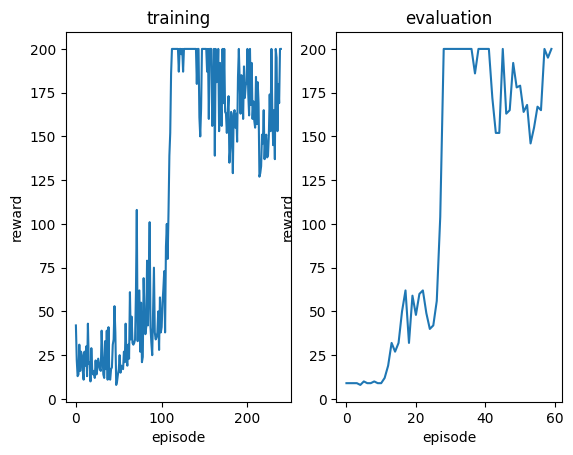

In [72]:
TRAINING_EVALUATION_RATIO = 5
EPISODES_PER_RUN = 300
STEPS_PER_EPISODE = 200

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the online SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` set to None. Also, leave the
#    `use_cql` and `offline` flags to remain False.
# 2) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
# 3) Plot the learning curves.
##########################################################
training_rewards = []
evaluation_rewards = []

online_agent = SACAgent(environment=env)
# eval_flag = 0

for episode in range(EPISODES_PER_RUN):
  state = env.reset()
  evaluation_episode = episode % TRAINING_EVALUATION_RATIO == 0
  total_reward = 0

  if evaluation_episode:
    for step in range(STEPS_PER_EPISODE):
        action = online_agent.get_next_action(state, evaluation_episode)
        next_state, reward, terminated, truncated = env.step(action)
        total_reward += reward
        done = truncated or terminated
        state = next_state
        if done:
          state = env.reset()
          break

    evaluation_rewards.append(total_reward)
    print('\r', f'evaluation; episode={episode}, total reward={total_reward}', end=' ')

  else:
    for step in range(STEPS_PER_EPISODE):
        action = online_agent.get_next_action(state, evaluation_episode)
        next_state, reward, terminated, truncated = env.step(action)
        total_reward += reward
        done = truncated or terminated

        online_agent.train_on_transition(state=state, discrete_action=action,
                    next_state=next_state, reward=reward, done=done)
        state = next_state
        if done:
          state = env.reset()
          break
    training_rewards.append(total_reward)
    print('\r', f'training; episode={episode}, total reward={total_reward}', end=' ')

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(training_rewards)
ax1.set_title('training')
ax1.set_xlabel('episode'), ax1.set_ylabel('reward')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(evaluation_rewards)
ax2.set_title('evaluation')
ax2.set_xlabel('episode'), ax2.set_ylabel('reward')

## Offline SAC training loop (10 points)

In this part you are going to train an SAC agent using the replay buffer from the online agent. During training you sample from this replay buffer and train the offline agent **without adding transitions to the replay buffer**. The loss function and every thing else is the same as the online setting.

Run: 0/5


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/300 [00:00<?, ?it/s]

evaluation; episode=0, total reward=11.0
evaluation; episode=10, total reward=11.0
evaluation; episode=20, total reward=11.0
evaluation; episode=30, total reward=18.0
evaluation; episode=40, total reward=10.0
evaluation; episode=50, total reward=11.0
evaluation; episode=60, total reward=11.0
evaluation; episode=70, total reward=11.0
evaluation; episode=80, total reward=13.0
evaluation; episode=90, total reward=10.0
evaluation; episode=100, total reward=17.0
evaluation; episode=110, total reward=9.0
evaluation; episode=120, total reward=10.0
evaluation; episode=130, total reward=9.0
evaluation; episode=140, total reward=13.0
evaluation; episode=150, total reward=12.0
evaluation; episode=160, total reward=11.0
evaluation; episode=170, total reward=13.0
evaluation; episode=180, total reward=11.0
evaluation; episode=190, total reward=11.0
evaluation; episode=200, total reward=12.0
evaluation; episode=210, total reward=12.0
evaluation; episode=220, total reward=13.0
evaluation; episode=230,

  0%|          | 0/300 [00:00<?, ?it/s]

evaluation; episode=0, total reward=9.0
evaluation; episode=10, total reward=9.0
evaluation; episode=20, total reward=9.0
evaluation; episode=30, total reward=10.0
evaluation; episode=40, total reward=9.0
evaluation; episode=50, total reward=9.0
evaluation; episode=60, total reward=9.0
evaluation; episode=70, total reward=10.0
evaluation; episode=80, total reward=10.0
evaluation; episode=90, total reward=9.0
evaluation; episode=100, total reward=9.0
evaluation; episode=110, total reward=9.0
evaluation; episode=120, total reward=10.0
evaluation; episode=130, total reward=9.0
evaluation; episode=140, total reward=8.0
evaluation; episode=150, total reward=8.0
evaluation; episode=160, total reward=9.0
evaluation; episode=170, total reward=8.0
evaluation; episode=180, total reward=9.0
evaluation; episode=190, total reward=10.0
evaluation; episode=200, total reward=8.0
evaluation; episode=210, total reward=10.0
evaluation; episode=220, total reward=9.0
evaluation; episode=230, total reward=1

  0%|          | 0/300 [00:00<?, ?it/s]

evaluation; episode=0, total reward=9.0
evaluation; episode=10, total reward=10.0
evaluation; episode=20, total reward=10.0
evaluation; episode=30, total reward=9.0
evaluation; episode=40, total reward=8.0
evaluation; episode=50, total reward=10.0
evaluation; episode=60, total reward=9.0
evaluation; episode=70, total reward=10.0
evaluation; episode=80, total reward=8.0
evaluation; episode=90, total reward=10.0
evaluation; episode=100, total reward=8.0
evaluation; episode=110, total reward=9.0
evaluation; episode=120, total reward=10.0
evaluation; episode=130, total reward=10.0
evaluation; episode=140, total reward=10.0
evaluation; episode=150, total reward=8.0
evaluation; episode=160, total reward=10.0
evaluation; episode=170, total reward=9.0
evaluation; episode=180, total reward=9.0
evaluation; episode=190, total reward=9.0
evaluation; episode=200, total reward=8.0
evaluation; episode=210, total reward=10.0
evaluation; episode=220, total reward=10.0
evaluation; episode=230, total rew

  0%|          | 0/300 [00:00<?, ?it/s]

evaluation; episode=0, total reward=8.0
evaluation; episode=10, total reward=9.0
evaluation; episode=20, total reward=9.0
evaluation; episode=30, total reward=8.0
evaluation; episode=40, total reward=10.0
evaluation; episode=50, total reward=8.0
evaluation; episode=60, total reward=10.0
evaluation; episode=70, total reward=10.0
evaluation; episode=80, total reward=10.0
evaluation; episode=90, total reward=10.0
evaluation; episode=100, total reward=9.0
evaluation; episode=110, total reward=10.0
evaluation; episode=120, total reward=9.0
evaluation; episode=130, total reward=8.0
evaluation; episode=140, total reward=10.0
evaluation; episode=150, total reward=11.0
evaluation; episode=160, total reward=10.0
evaluation; episode=170, total reward=9.0
evaluation; episode=180, total reward=9.0
evaluation; episode=190, total reward=9.0
evaluation; episode=200, total reward=9.0
evaluation; episode=210, total reward=9.0
evaluation; episode=220, total reward=10.0
evaluation; episode=230, total rewa

  0%|          | 0/300 [00:00<?, ?it/s]

evaluation; episode=0, total reward=10.0
evaluation; episode=10, total reward=9.0
evaluation; episode=20, total reward=8.0
evaluation; episode=30, total reward=8.0
evaluation; episode=40, total reward=10.0
evaluation; episode=50, total reward=9.0
evaluation; episode=60, total reward=10.0
evaluation; episode=70, total reward=9.0
evaluation; episode=80, total reward=9.0
evaluation; episode=90, total reward=9.0
evaluation; episode=100, total reward=10.0
evaluation; episode=110, total reward=10.0
evaluation; episode=120, total reward=11.0
evaluation; episode=130, total reward=9.0
evaluation; episode=140, total reward=10.0
evaluation; episode=150, total reward=10.0
evaluation; episode=160, total reward=9.0
evaluation; episode=170, total reward=9.0
evaluation; episode=180, total reward=9.0
evaluation; episode=190, total reward=8.0
evaluation; episode=200, total reward=9.0
evaluation; episode=210, total reward=9.0
evaluation; episode=220, total reward=9.0
evaluation; episode=230, total reward

(Text(0.5, 0, 'episode'), Text(0, 0.5, 'reward'))

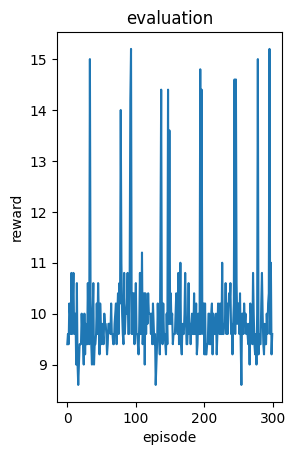

In [73]:
from tqdm.notebook import tqdm

RUNS = 5
NUM_EPOCHS = 300
EPISODES_PER_RUN = 300

env = gym.make("CartPole-v1")

##########################################################
# TODO (10 points):
# Implement the training loop for the offline SAC.
# 1) You need to initialize an agent with the
#    `replay_buffer` of the pretrained online agent. Set
#     the `offline` flag and leave the `use_cql` flag to
#     remain False.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
evaluation_rewards = [[] for _ in range(RUNS)]

for r in range(RUNS):
    print(f'Run: {r}/{RUNS}')
    offline_agent = SACAgent(environment=env, replay_buffer=online_agent.replay_buffer,
                                offline=True, use_cql=False)

    for epoch in tqdm(range(NUM_EPOCHS)):
        state = env.reset()
        total_reward = 0
        for step in range(STEPS_PER_EPISODE):
            action = offline_agent.get_next_action(state=state, evaluation_episode=False)
            next_state, reward, terminated, truncated = env.step(action)
            total_reward += reward
            done = truncated or terminated
            offline_agent.train_on_transition(state=state, discrete_action=action,
                next_state=next_state, reward=reward, done=done,
                batch_deterministic_start=True)
            state = next_state
            if done:
                state = env.reset()
                break

    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        total_reward = 0
        for step in range(STEPS_PER_EPISODE):
            action = offline_agent.get_next_action(state=state, evaluation_episode=True)
            next_state, reward, terminated, truncated = env.step(action)
            total_reward += reward
            done = truncated or terminated
            state = next_state
            if done:
                state = env.reset()
                break
        evaluation_rewards[r].append(total_reward)
        if episode % 10 == 0:
          print(f'evaluation; episode={episode}, total reward={total_reward}')

evaluation_rewards = np.array(evaluation_rewards).mean(0)

fig = plt.figure()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(evaluation_rewards)
ax2.set_title('evaluation')
ax2.set_xlabel('episode'), ax2.set_ylabel('reward')

## Conservative SAC training loop (5 points)

Similar to the previous part, you are going to train another offline agent. In this part, you are going to use the conservative version of SAC.

Run: 1/1


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


  0%|          | 0/200 [00:00<?, ?it/s]

evaluation; episode=0, total reward=9.0
evaluation; episode=1, total reward=8.0
evaluation; episode=2, total reward=9.0
evaluation; episode=3, total reward=10.0
evaluation; episode=4, total reward=10.0
evaluation; episode=5, total reward=9.0
evaluation; episode=6, total reward=9.0
evaluation; episode=7, total reward=10.0
evaluation; episode=8, total reward=10.0
evaluation; episode=9, total reward=10.0
evaluation; episode=10, total reward=8.0
evaluation; episode=11, total reward=10.0
evaluation; episode=12, total reward=10.0
evaluation; episode=13, total reward=10.0
evaluation; episode=14, total reward=8.0
evaluation; episode=15, total reward=9.0
evaluation; episode=16, total reward=10.0
evaluation; episode=17, total reward=10.0
evaluation; episode=18, total reward=10.0
evaluation; episode=19, total reward=10.0
evaluation; episode=20, total reward=10.0
evaluation; episode=21, total reward=10.0
evaluation; episode=22, total reward=10.0
evaluation; episode=23, total reward=9.0
evaluation;

(Text(0.5, 0, 'episode'), Text(0, 0.5, 'reward'))

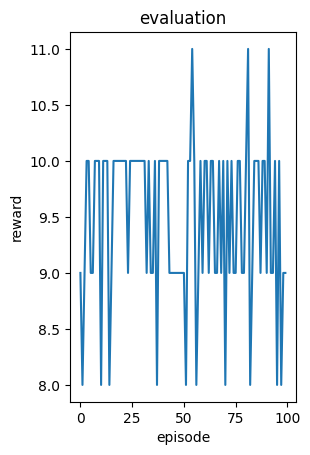

In [77]:
RUNS = 1
NUM_EPOCHS = 200
EPISODES_PER_RUN = 100

env = gym.make("CartPole-v1")

##########################################################
# TODO (5 points):
# Implement the training loop for the conservative SAC.
# 1) You need to initialize an agent with the current
#    `replay_buffer` of the online agent. Set the `offline`
#     and `use_cql` flags.
# 2) You can use `batch_deterministic_start` in the
#    `train_networks` method to select all minibatches
#    of the data to train in an offline manner.
# 3) After each epoch, run `EPISODES_PER_RUN` validation
#    episodes and plot the mean return over these
#    episodes in the end.
##########################################################
evaluation_rewards = [[] for _ in range(RUNS)]

for r in range(RUNS):
    print(f'Run: {r+1}/{RUNS}')

    offline_cql_agent = SACAgent(environment=env, replay_buffer=online_agent.replay_buffer,
                                    offline=True, use_cql=True)

    # offline_cql_agent.replay_buffer.set_mirror_indexes()

    for epoch in tqdm(range(NUM_EPOCHS)):
        replay_buffer_index = 0
        while replay_buffer_index < offline_cql_agent.replay_buffer.get_size():
            offline_cql_agent.train_networks(batch_deterministic_start=replay_buffer_index)
            replay_buffer_index += offline_cql_agent.REPLAY_BUFFER_BATCH_SIZE

    for episode in range(EPISODES_PER_RUN):
        state = env.reset()
        total_reward = 0
        for step in range(STEPS_PER_EPISODE):
            action = offline_cql_agent.get_next_action(state=state, evaluation_episode=True)
            next_state, reward, terminated, truncated = env.step(action)
            total_reward += reward
            done = truncated or terminated
            state = next_state
            if done:
                state = env.reset()
                break

        evaluation_rewards[r].append(total_reward)
        print(f'evaluation; episode={episode}, total reward={total_reward}')

evaluation_rewards = np.array(evaluation_rewards).mean(0)

fig = plt.figure()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(evaluation_rewards)
ax2.set_title('evaluation')
ax2.set_xlabel('episode'), ax2.set_ylabel('reward')

## Comparisons (14 points)
Now, analyze your results and justify the trends you see. Then answer the following questions.

❓ What is the reason for the difference between online and offline performance of the agent?

The difference between online and offline performance in reinforcement learning stems from the agent's ability to interact with the environment and learn from real-time feedback. In online settings, the agent explores and adapts its policies based on immediate results, whereas in offline settings, the agent lacks the opportunity for real-time exploration and may overestimate the values of actions absent from the training dataset. This discrepancy can lead to suboptimal performance in offline scenarios. To address this issue, a conservative loss is often employed to discourage exploration and ensure cautious behavior in the absence of direct feedback.

❓ Which one is better: offline SAC or conservative SAC?

In scenarios where there is a fixed dataset of experiences and no possibility for further interactions with the environment, Offline SAC might prove to be the better choice. This is because Offline SAC is specifically designed to optimize policies using batch data without online data collection. Its modifications are tailored to handle overestimation and extrapolation errors that are common in offline settings. Additionally, Offline SAC generally requires less computational overhead compared to Conservative SAC, which can be important in scenarios where computational resources are limited. The ability of Offline SAC to efficiently learn from static datasets without the need for additional interactions with the environment makes it particularly well-suited for situations where data collection is costly, risky, or infeasible.

❓ What is the effect of `TRADEOFF_FACTOR` in the offline setting? How does changing its value affect the results?

The `TRADEOFF_FACTOR` in an offline reinforcement learning setting acts as a weighting factor for the conservative loss component that encourages the agent to avoid unseen actions. Since the agent cannot interact with the environment to acquire new data in an offline setting, the conservative loss is crucial to prevent the agent from being over-optimistic about the values of actions it hasn't experienced. Setting the `TRADEOFF_FACTOR` to a higher value makes the agent more conservative, favoring actions present in the dataset and avoiding unexplored ones. Conversely, if the `TRADEOFF_FACTOR` is set to zero, the conservative loss component is effectively disabled, resulting in behavior akin to standard Offline SAC, where the agent does not explicitly avoid unseen actions. Balancing the `TRADEOFF_FACTOR` is key to achieving robust policies that effectively use the available data without extrapolating recklessly.